In [1]:
import pickle
import torch
from torch_geometric.data import Data, DataLoader
import model
from sklearn.metrics import f1_score

import os

RDKit WARNING: [14:32:03] Enabling RDKit 2019.09.3 jupyter extensions


### Load Dataset

In [ ]:
# f = open("./data/preprocessed/tcga_brca_dataset.pkl",'rb')
# data_list = pickle.load(f)
# f.close()

#f = open("./data/preprocessed/cv/tcga_brca_dataset_train_0.pkl",'rb')
#train_list = pickle.load(f)
#f.close()

#f = open("./data/preprocessed/cv/tcga_brca_dataset_test_0.pkl",'rb')
#test_list = pickle.load(f)
#f.close()

f = open("./data/preprocessed/cv/netics_exp_TF_z_norm_train_0.pkl",'rb')
train_list = pickle.load(f)
f.close()

f = open("./data/preprocessed/cv/netics_exp_TF_z_norm_test_0.pkl",'rb')
test_list = pickle.load(f)
f.close()

In [2]:
# f = open("./data/preprocessed/tcga_brca_dataset.pkl",'rb')
# data_list = pickle.load(f)
# f.close()
#netics
f = open("./data/preprocessed/cv/netics_exp_sample_train_0.pkl",'rb')
trainlist_sample = pickle.load(f)
f.close()

f = open("./data/preprocessed/cv/netics_exp_sample_test_0.pkl",'rb')
testlist_sample = pickle.load(f)
f.close()

f = open("./data/preprocessed/cv/netics_exp_TF_z_train_0.pkl",'rb')
trainlist_TF = pickle.load(f)
f.close()

f = open("./data/preprocessed/cv/netics_exp_TF_z_test_0.pkl",'rb')
testlist_TF = pickle.load(f)
f.close()
#len(test_list)

### Get Dataloader

In [3]:
train_loader = DataLoader(train_list,batch_size=1)
test_loader = DataLoader(test_list, batch_size=1)

In [3]:
#netics
trainloader_sample = DataLoader(trainlist_sample,batch_size=16)
testloader_sample = DataLoader(testlist_sample, batch_size=16)
trainloader_TF = DataLoader(trainlist_TF, batch_size=16)
testloader_TF = DataLoader(testlist_TF, batch_size=16)

### Model Configuration

In [4]:
#num_genes =9630
#netics
num_genes = 6016
num_class = 5
num_layers = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = model.simpleGCN(num_genes, num_class).to(device)
model = model.pagerank_explain(num_genes,num_class).to(device)
loss_op = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

save_path = "./data/model/pagerank_explain"
print("Save path:", save_path)

pagerank_explain: K:1, alpha:0.1, dropout:0.5
cuda
Save path: ./data/model/pagerank_explain


### Train and Test

In [5]:
def train():
    model.train()
    
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_op(output, data.y)
        total_loss+=loss.item()*data.num_graphs
        loss.backward()
        optimizer.step()
                    
    return total_loss / len(train_loader.dataset)

def test(loader):
    model.eval()

    ys, preds = [], []
    for data in loader:
        ys.append(data.y)
        out = model(data.to(device))
        pred = out.max(dim=1)[1]
        preds.append(pred.cpu())
        #print(preds)
    
    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='weighted') if pred.sum() > 0 else 0

In [5]:
#netics

def train():
    model.train()
    
    total_loss = 0
    for data1, data2 in zip(trainloader_sample, trainloader_TF):
        data1 = data1.to(device)
        data2 = data2.to(device)
        
        optimizer.zero_grad()
        output = model(data1, data2)
        loss = loss_op(output, data1.y)
        total_loss+=loss.item()*data1.num_graphs
        loss.backward()
        optimizer.step()
                    
    return total_loss / len(trainloader_sample.dataset)

def test(loader1, loader2):
    model.eval()

    ys, preds = [], []
    for data1, data2 in zip(loader1, loader2):
        ys.append(data1.y)
        out = model(data1.to(device),data2.to(device))
        pred = out.max(dim=1)[1]
        preds.append(pred.cpu())
    
    y, pred = torch.cat(ys, dim=0).numpy(), torch.cat(preds, dim=0).numpy()
    return f1_score(y, pred, average='weighted') if pred.sum() > 0 else 0

In [ ]:
if not os.path.exists(save_path):
    os.makedirs(save_path)
        
for epoch in range(1, 3):
    loss = train()
    
    if epoch%100 == 0:
        torch.save(model.state_dict(),save_path+"/model_epoch{}".format(epoch))

    test_f1 = test(test_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Test: {:.4f}'.format(epoch, loss, test_f1))

In [6]:
#netics
if not os.path.exists(save_path):
    os.makedirs(save_path)
    
early_patience = 20
best_test = 0.1607

for epoch in range(1, 301):
    loss = train()

    test_f1 = test(testloader_sample, testloader_TF)
    torch.save({'epoch':epoch, 'model_state_dict':model.state_dict(),'testscore': test_f1, 'loss': loss}, save_path+"/model_dict")
    
    print('Epoch: {:02d}, Loss: {:.4f}, Test: {:.4f}'.format(epoch, loss, test_f1))

    if test_f1 > best_test:
        best_test = test_f1
        best_epoch = epoch
        torch.save({'epoch':best_epoch, 'model_state_dict':model.state_dict(),'bestscore': best_test,'loss': loss}, save_path+"/best_model_h_dict")
    if test_f1 > 0.8 and test_f1 < best_test:
        if early_patience > 0:
            early_patience -= 1
            print(early_patience)
        else:
            break

/home/minjae/miniconda3/envs/minjae/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch: 01, Loss: 2.1569, Test: 0.0823
Epoch: 02, Loss: 1.4785, Test: 0.2910
Epoch: 03, Loss: 1.3530, Test: 0.2939
Epoch: 04, Loss: 1.1827, Test: 0.3843
Epoch: 05, Loss: 0.9649, Test: 0.4004
Epoch: 06, Loss: 0.7859, Test: 0.4148
Epoch: 07, Loss: 0.6618, Test: 0.4883
Epoch: 08, Loss: 0.6030, Test: 0.5702
Epoch: 09, Loss: 0.5406, Test: 0.5843
Epoch: 10, Loss: 0.5123, Test: 0.6747
Epoch: 11, Loss: 0.4954, Test: 0.6665
Epoch: 12, Loss: 0.4672, Test: 0.7080
Epoch: 13, Loss: 0.4294, Test: 0.7064
Epoch: 14, Loss: 0.3972, Test: 0.7137
Epoch: 15, Loss: 0.3631, Test: 0.6410
Epoch: 16, Loss: 0.3555, Test: 0.6994
Epoch: 17, Loss: 0.3456, Test: 0.6161
Epoch: 18, Loss: 0.3469, Test: 0.6763
Epoch: 19, Loss: 0.3420, Test: 0.6786
Epoch: 20, Loss: 0.3111, Test: 0.7710
Epoch: 21, Loss: 0.2923, Test: 0.8098
Epoch: 22, Loss: 0.2530, Test: 0.7857
Epoch: 23, Loss: 0.2497, Test: 0.7845
Epoch: 24, Loss: 0.2414, Test: 0.7745
Epoch: 25, Loss: 0.2257, Test: 0.7217
Epoch: 26, Loss: 0.2416, Test: 0.7670
Epoch: 27, L

In [7]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
import explainer_graph

In [8]:
checkpoint = torch.load('./data/model/pagerank_explain/best_model_h_dict')

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
save = []

for i in range(len(testlist_sample)):
    target = testlist_sample[i].y.cpu().detach().numpy()
    pred = model(testlist_sample[i], testlist_TF[i],False)
    probs = torch.softmax(pred,1)
    pred_label = probs.argmax(dim=-1).cpu().detach().numpy()
    if target[0]==1 and pred_label[0]==1:
        save.append({pred_label[0]:i})
        
len(save)        

25

In [9]:
explainer = explainer_graph.GNNExplainer_lite(model, epochs=500)

cuda


In [10]:
mask_adj,epoch_losses = explainer.explain_graph(testlist_sample[3],testlist_TF[3],2)

predlabel: tensor([2], device='cuda:0')


In [9]:
with open('./result/0','rb') as f:
    act = pickle.load(f)

In [16]:
act.max()

2.5655038

In [21]:
temp = act[0].argsort()
rank = np.arange(len(act[0]))[temp.argsort()]

In [25]:
rank=12031 - rank

In [50]:
rank[1577]

247

In [19]:
act[0][1597]

0.37471232

In [9]:
with open('./result/class0/act_top10rand_0','rb') as f:
    actrand = pickle.load(f)

In [10]:
actrand

[1979, 1995, 1546, 1989, 7995, 8011, 1969, 5289, 5232, 4385]

In [9]:
with open('./masking_adj_rand.pkl','rb') as f:
    maskingrand = pickle.load(f)

In [10]:
np.where(maskingrand == maskingrand.max())

(array([1038]), array([0]))

In [14]:
maskingrand.max()

0.5587579

In [10]:
with open('./masking_ad1.pkl','rb') as f:
    masking0 = pickle.load(f)

In [11]:
with open('./masking_adj.pkl','rb') as f:
    masking1 = pickle.load(f)

In [12]:
with open('./masking_adj2.pkl','rb') as f:
    masking100 = pickle.load(f)

In [15]:
print(masking100.max(),masking100.min(),masking100.mean())

1.5211802 0.0 0.57583386


In [27]:
np.where(masking1 ==1.4961052   )

(array([2118]), array([0]))

In [26]:
masking1[612]

array([0.], dtype=float32)

In [13]:
print(masking1.max(),masking1.min(),masking1.mean())

1.4961052 0.0 0.5811962


In [14]:
print(masking0.max(),masking0.min(),masking0.mean())

1.5297971 0.0 0.5920594


In [38]:
masking1

array([[1.3120971 ],
       [0.69014287],
       [0.64686245],
       ...,
       [0.        ],
       [0.8430305 ],
       [1.0084229 ]], dtype=float32)

In [39]:
masking0

array([[0.99738914],
       [0.04124273],
       [0.93241155],
       ...,
       [0.0266945 ],
       [0.6233532 ],
       [1.1868773 ]], dtype=float32)

In [40]:
masking100

array([[1.1947447 ],
       [0.5732574 ],
       [0.7329316 ],
       ...,
       [0.4989627 ],
       [0.72794676],
       [0.        ]], dtype=float32)

In [29]:
with open('./result/class0/act_top10/act_top10_0','rb') as f:
    act = pickle.load(f)

In [11]:
with open('./data/preprocessed/netics_G_un_edgeindex.pkl', 'rb') as f:
    netics = pickle.load(f)

Nodes are not connected


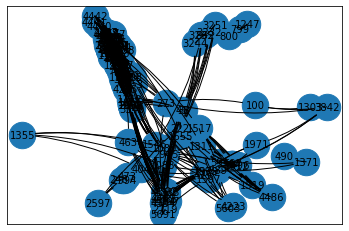

In [87]:
ori_gene,sub_gene = explainer.visualize_subgraph(mask_adj,netics,10,1,41)

In [9]:
for i in [7,17,28,55,82]:
    mask_adj,epoch_losses = explainer.explain_graph(testlist_sample[i],testlist_TF[i],i)
    #ori_gene,sub_gene = explainer.visualize_subgraph(mask_adj,netics,30,'1/htop30',i)

predlabel: tensor([4], device='cuda:0')
predlabel: tensor([4], device='cuda:0')
predlabel: tensor([4], device='cuda:0')
predlabel: tensor([4], device='cuda:0')
predlabel: tensor([4], device='cuda:0')


In [12]:
from collections import Counter
gene = []
subnone = []
for i in [6,15,16,20,23,24,29,33,36,45,48,51,54,58,62,65,71,72,89,91,93,97]:
    with open('./result/class3/act_top10/{}'.format(i),'rb') as f:
        file = pickle.load(f)
        #gene_list = list(map(lambda x:x[0],file))
        gene.extend(file)
    for j in range(len(gene)):
        if gene[j] > 6015:
            gene[j] = gene[j] - 6015

        
counter = Counter(gene)
    

In [13]:
counter.most_common()

[(1979, 17),
 (273, 15),
 (1546, 13),
 (100, 10),
 (1980, 10),
 (1303, 10),
 (4162, 9),
 (1989, 8),
 (4385, 8),
 (4383, 8),
 (3347, 7),
 (4384, 7),
 (1995, 6),
 (2586, 6),
 (2936, 6),
 (4515, 6),
 (1970, 5),
 (5232, 5),
 (3226, 4),
 (4393, 4),
 (777, 4),
 (4822, 4),
 (2945, 4),
 (1820, 4),
 (2880, 3),
 (4166, 3),
 (1968, 3),
 (4342, 3),
 (4409, 3),
 (38, 3),
 (1969, 2),
 (5289, 2),
 (1142, 2),
 (1990, 2),
 (807, 2),
 (1996, 1),
 (4167, 1),
 (4163, 1),
 (1977, 1),
 (1143, 1),
 (605, 1),
 (4225, 1),
 (4437, 1),
 (4214, 1),
 (1083, 1),
 (5756, 1),
 (1972, 1)]

In [14]:
with open('./data/preprocessed/netics_node_mapping.pkl', 'rb') as f:
    mapping = pickle.load(f)

In [15]:
list(mapping.items())[1979]

('GNB1', 1979)

In [16]:
gene_list = []
none =[]
for i,j in counter.most_common():
    try:
        gene_list.append((list(mapping.items())[i],j))
    except:
        none.append(i)
gene_list

[(('GNB1', 1979), 17),
 (('ARTN', 273), 15),
 (('EP300', 1546), 13),
 (('AEBP2', 100), 10),
 (('GNB2', 1980), 10),
 (('DKFZP686L0365', 1303), 10),
 (('PIK3CA', 4162), 9),
 (('GNG2', 1989), 8),
 (('PRKACG', 4385), 8),
 (('PRKACA', 4383), 8),
 (('NFKB1', 3347), 7),
 (('PRKACB', 4384), 7),
 (('GNGT1', 1995), 6),
 (('JUN', 2586), 6),
 (('MAPK1', 2936), 6),
 (('PTPN11', 4515), 6),
 (('GNAI3', 1970), 5),
 (('SRC', 5232), 5),
 (('MYC', 3226), 4),
 (('PRKCA', 4393), 4),
 (('CDK1', 777), 4),
 (('RPS28', 4822), 4),
 (('MAPK8', 2945), 4),
 (('FYN', 1820), 4),
 (('LYN', 2880), 3),
 (('PIK3R1', 4166), 3),
 (('GNAI1', 1968), 3),
 (('PPP2R1A', 4342), 3),
 (('PRKX', 4409), 3),
 (('ACTBL2', 38), 3),
 (('GNAI2', 1969), 2),
 (('STAT3', 5289), 2),
 (('CTNNB1', 1142), 2),
 (('GNG3', 1990), 2),
 (('CEBPB', 807), 2),
 (('GNGT2', 1996), 1),
 (('PIK3R2', 4167), 1),
 (('PIK3CB', 4163), 1),
 (('GNAT3', 1977), 1),
 (('CTNNBL1', 1143), 1),
 (('CBLB', 605), 1),
 (('PLK1', 4225), 1),
 (('PSMA1', 4437), 1),
 (('PLCG1

In [17]:
netics.numpy()[]

array([   0,    0,    0, ..., 6011, 6011, 6012])

In [12]:
from torch_geometric.utils import k_hop_subgraph
subset, edge_index, inv, edge_mask = k_hop_subgraph(4869,1,netics,num_nodes=6016)

In [13]:
subset

tensor([  38,   43,  190,  467,  586,  814,  815,  818,  819,  821,  822,  823,
         824,  825,  826,  827,  828,  829,  830, 1083, 1142, 1269, 1282, 1341,
        1546, 1547, 1553, 1779, 2214, 2224, 2225, 2479, 2485, 2560, 2596, 2782,
        2967, 2998, 3053, 3054, 3089, 3090, 3099, 3226, 3362, 3423, 3539, 4022,
        4641, 4643, 4753, 4856, 4869])

### Reference 
@torch.no_grad()
#https://github.com/rusty1s/pytorch_geometric/blob/master/examples/ppi.py
#https://github.com/rusty1s/pytorch_geometric/blob/master/examples/proteins_topk_pool.py
